input: embeddings, metadata (genus, family, host); embeddings are mapped with headers and headers are aligned with metadata by accession number

output: supervised MLP model that predicts genus, family, host based on embeddings

dataset: separate 90% of them to train and 10% of them to validate

loss function: try hierarchical loss for the taxonomic labels


In [1]:
import numpy as np
import pandas as pd

# MLP training

## megaDNA

In [2]:
embeddings_megadna = np.load("../results/embeddings_megaDNA.npy")
headers_megadna = np.load("../results/headers_megaDNA.npy")
metadata_cleaned = pd.read_csv(
    "../dataset/metadata_millard_cleaned_host_genus_family_class.tsv", sep="\t"
)

In [3]:
headers_megadna

array(['AY319521 Salmonella phage SopEPhi, complete sequence.',
       'AC171169 Escherichia phage H8 clone h8_phage, WORKING DRAFT SEQUENCE.',
       'AY576273 Alphaproteobacteria phage PhiJL001, complete genome.',
       ..., 'PP856269 Escherichia phage UFJF_EcSW4, complete genome.',
       'PQ261042 Pseudomonas phage Minga_mokiny_4, complete genome.',
       'PQ374047 Salmonella phage vB_SeTS_UALMA_PCST1, partial genome.'],
      shape=(8069,), dtype='<U394')

Original embeddings count: 8069
Matched embeddings count: 7997
Percentage retained: 99.11%
Number of genus classes: 506
Number of family classes: 69
Number of class classes: 10
Number of host classes: 131
Epoch 1/20
Train Loss: 6.2956, Val Loss: 3.3235
Train Accuracies: {'genus': '0.4924', 'family': '0.8415', 'class': '0.9536', 'host': '0.4959'}
Val Accuracies: {'genus': '0.6587', 'family': '0.9475', 'class': '0.9888', 'host': '0.6562'}
Epoch 2/20
Train Loss: 2.9681, Val Loss: 2.3807
Train Accuracies: {'genus': '0.6717', 'family': '0.9486', 'class': '0.9887', 'host': '0.6719'}
Val Accuracies: {'genus': '0.7212', 'family': '0.9675', 'class': '0.9925', 'host': '0.7425'}
Epoch 3/20
Train Loss: 2.1438, Val Loss: 1.8206
Train Accuracies: {'genus': '0.7425', 'family': '0.9686', 'class': '0.9940', 'host': '0.7289'}
Val Accuracies: {'genus': '0.7913', 'family': '0.9862', 'class': '0.9988', 'host': '0.7662'}
Epoch 4/20
Train Loss: 1.7125, Val Loss: 1.5423
Train Accuracies: {'genus': '0.7878', '

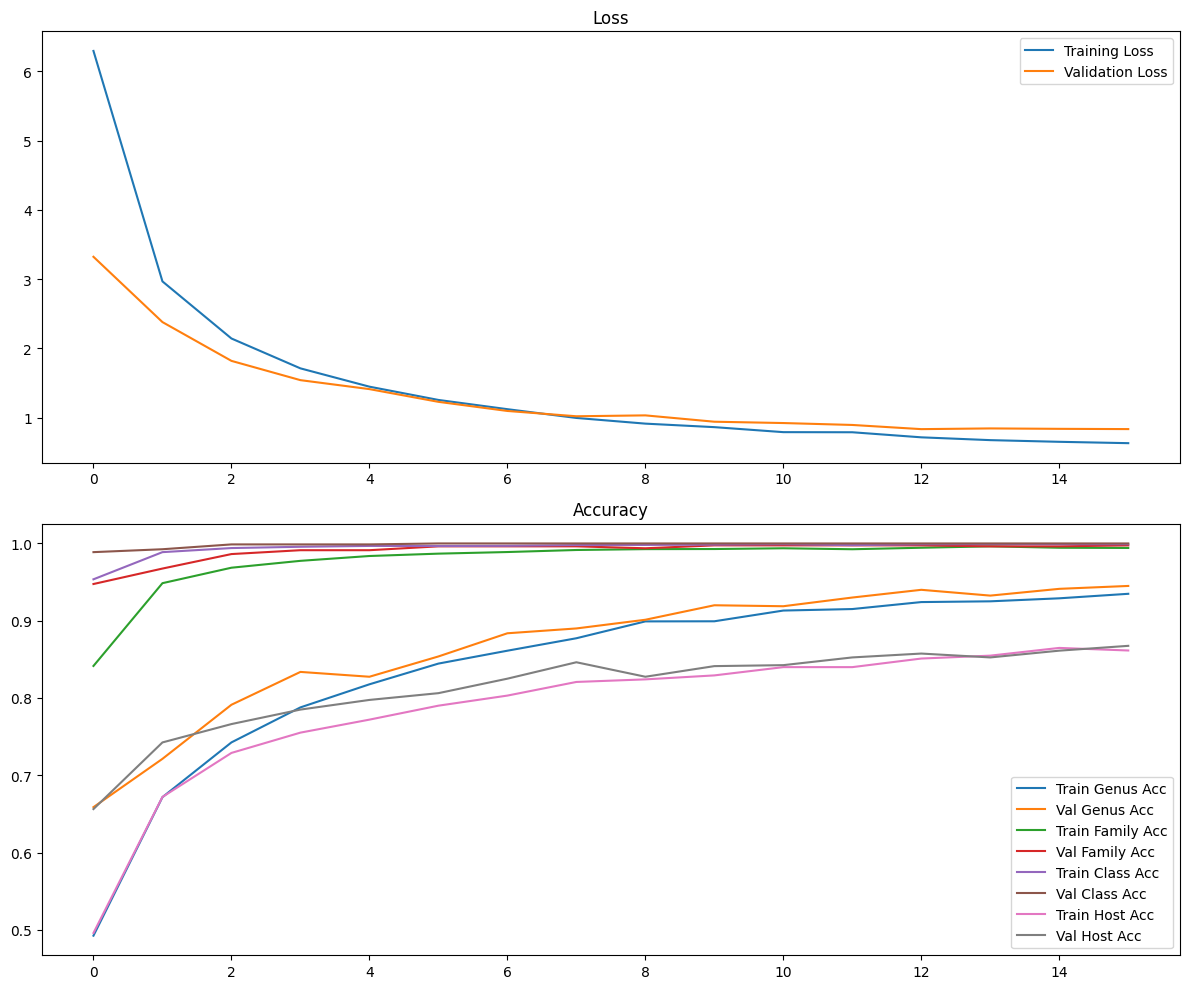

Training completed and model saved successfully!


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Data preparation
accession_numbers = [header.split()[0] for header in headers_megadna]
embeddings_df = pd.DataFrame(embeddings_megadna)
embeddings_df["Accession"] = accession_numbers

# Merge with metadata - only keep embeddings with matching accession numbers
merged_data = pd.merge(embeddings_df, metadata_cleaned, on="Accession", how="inner")

# Print info about the merge
print(f"Original embeddings count: {len(embeddings_megadna)}")
print(f"Matched embeddings count: {len(merged_data)}")
print(f"Percentage retained: {len(merged_data)/len(embeddings_megadna)*100:.2f}%")

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data.iloc[:, : embeddings_megadna.shape[1]].values)

# Encode targets - now including Class
genus_encoder = LabelEncoder()
family_encoder = LabelEncoder()
class_encoder = LabelEncoder()  # New encoder for Class
host_encoder = LabelEncoder()

y_genus = genus_encoder.fit_transform(merged_data["Genus"])
y_family = family_encoder.fit_transform(merged_data["Family"])
y_class = class_encoder.fit_transform(merged_data["Class"])  # Encode Class
y_host = host_encoder.fit_transform(merged_data["Host"])

# Print class counts
print(f"Number of genus classes: {len(genus_encoder.classes_)}")
print(f"Number of family classes: {len(family_encoder.classes_)}")
print(f"Number of class classes: {len(class_encoder.classes_)}")  # New
print(f"Number of host classes: {len(host_encoder.classes_)}")


# Create PyTorch Dataset - now including Class
class TaxonomyDataset(Dataset):
    def __init__(self, X, y_genus, y_family, y_class, y_host):
        self.X = torch.FloatTensor(X)
        self.y_genus = torch.LongTensor(y_genus)
        self.y_family = torch.LongTensor(y_family)
        self.y_class = torch.LongTensor(y_class)  # New
        self.y_host = torch.LongTensor(y_host)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            self.X[idx],
            self.y_genus[idx],
            self.y_family[idx],
            self.y_class[idx],  # New
            self.y_host[idx],
        )


# Split data - now including Class
(
    X_train,
    X_val,
    y_genus_train,
    y_genus_val,
    y_family_train,
    y_family_val,
    y_class_train,
    y_class_val,
    y_host_train,
    y_host_val,
) = train_test_split(X, y_genus, y_family, y_class, y_host, test_size=0.1, random_state=42)

# Create datasets
train_dataset = TaxonomyDataset(X_train, y_genus_train, y_family_train, y_class_train, y_host_train)
val_dataset = TaxonomyDataset(X_val, y_genus_val, y_family_val, y_class_val, y_host_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Define model - now including Class
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, genus_classes, family_classes, class_classes, host_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.genus_classifier = nn.Linear(256, genus_classes)
        self.family_classifier = nn.Linear(256, family_classes)
        self.class_classifier = nn.Linear(256, class_classes)  # New
        self.host_classifier = nn.Linear(256, host_classes)

    def forward(self, x):
        shared_features = self.shared_layers(x)
        return {
            "genus": self.genus_classifier(shared_features),
            "family": self.family_classifier(shared_features),
            "class": self.class_classifier(shared_features),  # New
            "host": self.host_classifier(shared_features),
        }


# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=X.shape[1],
    genus_classes=len(genus_encoder.classes_),
    family_classes=len(family_encoder.classes_),
    class_classes=len(class_encoder.classes_),  # New
    host_classes=len(host_encoder.classes_),
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training function - now including Class
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "class": 0, "host": 0}  # Added class
    total_samples = 0

    for batch in train_loader:
        x, y_genus, y_family, y_class, y_host = [b.to(device) for b in batch]  # Added y_class
        optimizer.zero_grad()

        outputs = model(x)

        # Calculate losses with weights - now including Class
        # Higher weights for higher taxonomic levels
        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)
            + 2.0 * criterion(outputs["class"], y_class)  # New - highest weight for Class
            + 1.0 * criterion(outputs["host"], y_host)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracies
        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "class": y_class, "host": y_host}[
                task
            ]  # Added class
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Validation function - now including Class
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "class": 0, "host": 0}  # Added class
    total_samples = 0

    for batch in val_loader:
        x, y_genus, y_family, y_class, y_host = [b.to(device) for b in batch]  # Added y_class
        outputs = model(x)

        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)
            + 2.0 * criterion(outputs["class"], y_class)  # New
            + 1.0 * criterion(outputs["host"], y_host)
        )

        total_loss += loss.item()

        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "class": y_class, "host": y_host}[
                task
            ]  # Added class
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Training loop
num_epochs = 20
best_val_loss = float("inf")
patience = 3
patience_counter = 0
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": {"genus": [], "family": [], "class": [], "host": []},  # Added class
    "val_acc": {"genus": [], "family": [], "class": [], "host": []},  # Added class
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Store metrics
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    for task in ["genus", "family", "class", "host"]:  # Added class
        history["train_acc"][task].append(train_acc[task])
        history["val_acc"][task].append(val_acc[task])

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print("Train Accuracies:", {k: f"{v:.4f}" for k, v in train_acc.items()})
    print("Val Accuracies:", {k: f"{v:.4f}" for k, v in val_acc.items()})

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
            },
            "../models/taxonomy_mlp_model.pt",
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot results
plt.figure(figsize=(12, 10))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

# Plot accuracies
plt.subplot(2, 1, 2)
for task in ["genus", "family", "class", "host"]:  # Added class
    plt.plot(history["train_acc"][task], label=f"Train {task.capitalize()} Acc")
    plt.plot(history["val_acc"][task], label=f"Val {task.capitalize()} Acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Save encoders
with open("../models/label_encoders.pkl", "wb") as f:
    pickle.dump(
        {
            "genus_encoder": genus_encoder,
            "family_encoder": family_encoder,
            "class_encoder": class_encoder,  # New
            "host_encoder": host_encoder,
            "scaler": scaler,
        },
        f,
    )

print("Training completed and model saved successfully")

## evo2

In [3]:
embeddings_evo2 = np.load("../results/embeddings_evo2_30k.npy")
headers_evo2 = pd.read_csv("../results/headers_evo2.csv")
metadata_cleaned = pd.read_csv(
    "../dataset/metadata_millard_cleaned_host_genus_family_class.tsv", sep="\t"
)

In [5]:
headers_evo2

,header
0,"MN335248 Xanthomonas phage XaF13, complete gen..."
1,"MG592615 Vibrio phage 1.249.A._10N.261.55.B9, ..."
2,"MG592455 Vibrio phage 1.080.O._10N.286.48.A4, ..."
3,"MG592427 Vibrio phage 1.044.O._10N.261.51.B8, ..."
4,"MG592402 Vibrio phage 1.020.O._10N.222.48.A2, ..."
...,...
3295,X60322 Coliphage alpha3 complete genome.
3296,AJ635161 Pyrobaculum spherical virus complete ...
3297,"AJ550635 Chlamydia phage 3, complete genome."
3298,"AJ270057 Chlamydia phage 2 DNA, complete genome."


Original embeddings count: 3300
Matched embeddings count: 3231
Percentage retained: 97.91%
Number of genus classes: 108
Number of family classes: 28
Number of class classes: 10
Number of host classes: 52
Epoch 1/20
Train Loss: 7.9529, Val Loss: 4.5158
Train Accuracies: {'genus': '0.6023', 'family': '0.7568', 'class': '0.7809', 'host': '0.4407'}
Val Accuracies: {'genus': '0.7130', 'family': '0.8210', 'class': '0.8488', 'host': '0.5556'}
Epoch 2/20
Train Loss: 4.7620, Val Loss: 3.9734
Train Accuracies: {'genus': '0.7238', 'family': '0.8270', 'class': '0.8507', 'host': '0.5738'}
Val Accuracies: {'genus': '0.7562', 'family': '0.8333', 'class': '0.8580', 'host': '0.5926'}
Epoch 3/20
Train Loss: 4.0526, Val Loss: 3.4116
Train Accuracies: {'genus': '0.7599', 'family': '0.8442', 'class': '0.8614', 'host': '0.6089'}
Val Accuracies: {'genus': '0.7593', 'family': '0.8642', 'class': '0.8765', 'host': '0.6265'}
Epoch 4/20
Train Loss: 3.5300, Val Loss: 3.3217
Train Accuracies: {'genus': '0.7816', 'f

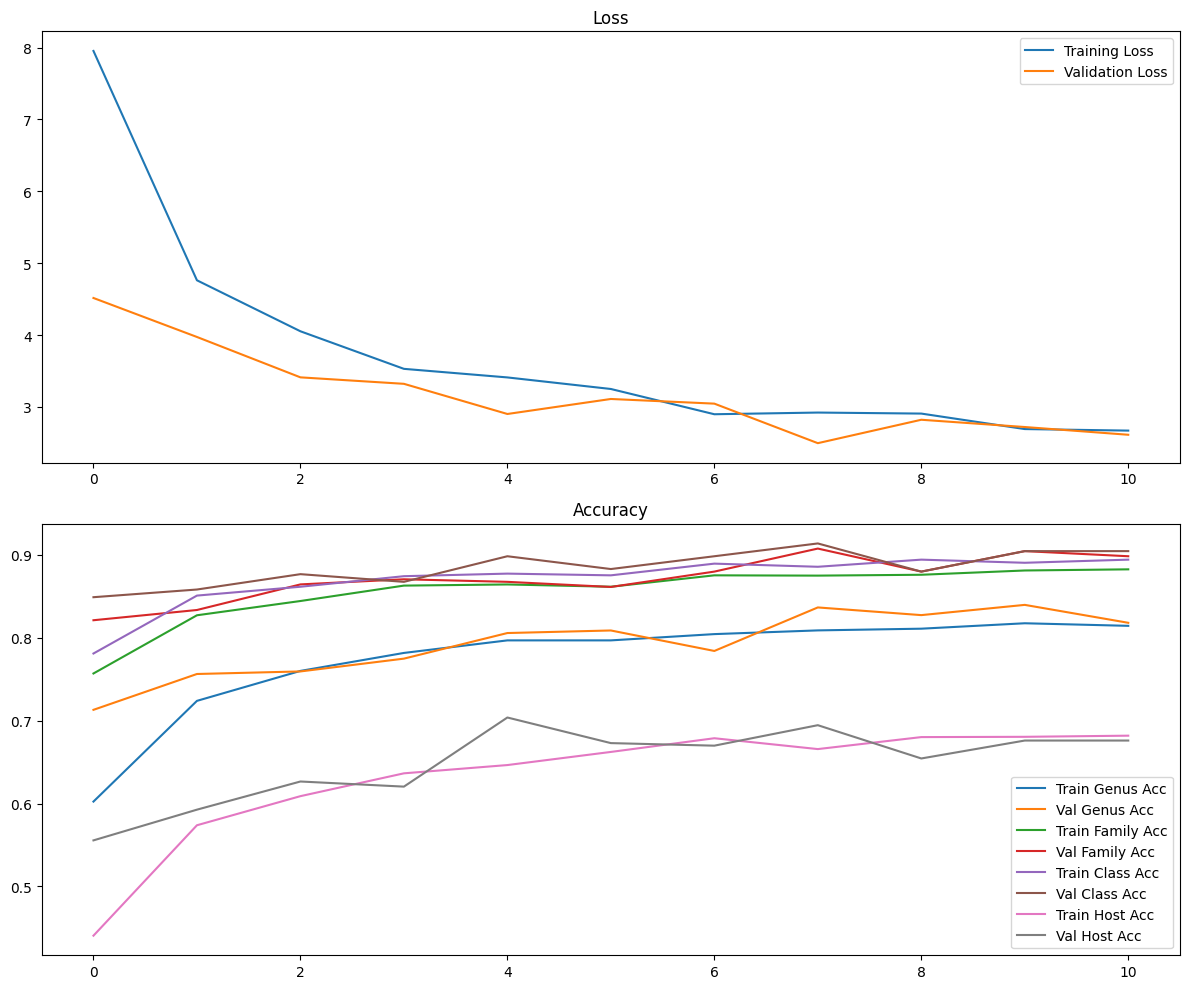

Training completed and model saved successfully


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import pickle

# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Data preparation
accession_numbers = [header.split()[0] for header in headers_evo2["header"]]
embeddings_df = pd.DataFrame(embeddings_evo2)
embeddings_df["Accession"] = accession_numbers

# Merge with metadata - only keep embeddings with matching accession numbers
merged_data = pd.merge(embeddings_df, metadata_cleaned, on="Accession", how="inner")

# Print info about the merge
print(f"Original embeddings count: {len(embeddings_evo2)}")
print(f"Matched embeddings count: {len(merged_data)}")
print(f"Percentage retained: {len(merged_data)/len(embeddings_evo2)*100:.2f}%")

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(merged_data.iloc[:, : embeddings_evo2.shape[1]].values)

# Encode targets - now including Class
genus_encoder = LabelEncoder()
family_encoder = LabelEncoder()
class_encoder = LabelEncoder()  # New encoder for Class
host_encoder = LabelEncoder()

y_genus = genus_encoder.fit_transform(merged_data["Genus"])
y_family = family_encoder.fit_transform(merged_data["Family"])
y_class = class_encoder.fit_transform(merged_data["Class"])  # Encode Class
y_host = host_encoder.fit_transform(merged_data["Host"])

# Print class counts
print(f"Number of genus classes: {len(genus_encoder.classes_)}")
print(f"Number of family classes: {len(family_encoder.classes_)}")
print(f"Number of class classes: {len(class_encoder.classes_)}")  # New
print(f"Number of host classes: {len(host_encoder.classes_)}")


# Create PyTorch Dataset - now including Class
class TaxonomyDataset(Dataset):
    def __init__(self, X, y_genus, y_family, y_class, y_host):
        self.X = torch.FloatTensor(X)
        self.y_genus = torch.LongTensor(y_genus)
        self.y_family = torch.LongTensor(y_family)
        self.y_class = torch.LongTensor(y_class)  # New
        self.y_host = torch.LongTensor(y_host)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            self.X[idx],
            self.y_genus[idx],
            self.y_family[idx],
            self.y_class[idx],  # New
            self.y_host[idx],
        )


# Split data - now including Class
(
    X_train,
    X_val,
    y_genus_train,
    y_genus_val,
    y_family_train,
    y_family_val,
    y_class_train,
    y_class_val,
    y_host_train,
    y_host_val,
) = train_test_split(X, y_genus, y_family, y_class, y_host, test_size=0.1, random_state=42)

# Create datasets
train_dataset = TaxonomyDataset(X_train, y_genus_train, y_family_train, y_class_train, y_host_train)
val_dataset = TaxonomyDataset(X_val, y_genus_val, y_family_val, y_class_val, y_host_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Define model - now including Class
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, genus_classes, family_classes, class_classes, host_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.genus_classifier = nn.Linear(256, genus_classes)
        self.family_classifier = nn.Linear(256, family_classes)
        self.class_classifier = nn.Linear(256, class_classes)  # New
        self.host_classifier = nn.Linear(256, host_classes)

    def forward(self, x):
        shared_features = self.shared_layers(x)
        return {
            "genus": self.genus_classifier(shared_features),
            "family": self.family_classifier(shared_features),
            "class": self.class_classifier(shared_features),  # New
            "host": self.host_classifier(shared_features),
        }


# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=X.shape[1],
    genus_classes=len(genus_encoder.classes_),
    family_classes=len(family_encoder.classes_),
    class_classes=len(class_encoder.classes_),  # New
    host_classes=len(host_encoder.classes_),
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Training function - now including Class
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "class": 0, "host": 0}  # Added class
    total_samples = 0

    for batch in train_loader:
        x, y_genus, y_family, y_class, y_host = [b.to(device) for b in batch]  # Added y_class
        optimizer.zero_grad()

        outputs = model(x)

        # Calculate losses with weights - now including Class
        # Higher weights for higher taxonomic levels
        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)
            + 2.0 * criterion(outputs["class"], y_class)  # New - highest weight for Class
            + 1.0 * criterion(outputs["host"], y_host)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracies
        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "class": y_class, "host": y_host}[
                task
            ]  # Added class
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Validation function - now including Class
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = {"genus": 0, "family": 0, "class": 0, "host": 0}  # Added class
    total_samples = 0

    for batch in val_loader:
        x, y_genus, y_family, y_class, y_host = [b.to(device) for b in batch]  # Added y_class
        outputs = model(x)

        loss = (
            1.0 * criterion(outputs["genus"], y_genus)
            + 1.5 * criterion(outputs["family"], y_family)
            + 2.0 * criterion(outputs["class"], y_class)  # New
            + 1.0 * criterion(outputs["host"], y_host)
        )

        total_loss += loss.item()

        for task, output in outputs.items():
            pred = output.argmax(dim=1)
            target = {"genus": y_genus, "family": y_family, "class": y_class, "host": y_host}[
                task
            ]  # Added class
            total_correct[task] += (pred == target).sum().item()

        total_samples += x.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracies = {task: correct / total_samples for task, correct in total_correct.items()}

    return avg_loss, accuracies


# Training loop
num_epochs = 20
best_val_loss = float("inf")
patience = 3
patience_counter = 0
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": {"genus": [], "family": [], "class": [], "host": []},  # Added class
    "val_acc": {"genus": [], "family": [], "class": [], "host": []},  # Added class
}

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Store metrics
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    for task in ["genus", "family", "class", "host"]:  # Added class
        history["train_acc"][task].append(train_acc[task])
        history["val_acc"][task].append(val_acc[task])

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print("Train Accuracies:", {k: f"{v:.4f}" for k, v in train_acc.items()})
    print("Val Accuracies:", {k: f"{v:.4f}" for k, v in val_acc.items()})

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
            },
            "../models/taxonomy_mlp_model_evo2.pt",
        )
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot results
plt.figure(figsize=(12, 10))

# Plot loss
plt.subplot(2, 1, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.legend()

# Plot accuracies
plt.subplot(2, 1, 2)
for task in ["genus", "family", "class", "host"]:  # Added class
    plt.plot(history["train_acc"][task], label=f"Train {task.capitalize()} Acc")
    plt.plot(history["val_acc"][task], label=f"Val {task.capitalize()} Acc")
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# Save encoders
with open("../models/label_encoders_evo2.pkl", "wb") as f:
    pickle.dump(
        {
            "genus_encoder": genus_encoder,
            "family_encoder": family_encoder,
            "class_encoder": class_encoder,  # New
            "host_encoder": host_encoder,
            "scaler": scaler,
        },
        f,
    )

print("Training completed and model saved successfully")

# Testing

## megaDNA

In [2]:
metadata_matrix_class = pd.read_csv(
    "../dataset/matrix_metadata_class.tsv", sep="\t"
)  # Class info is in the Class column; this dataframe contains instances used for Class classification
metadata_matrix_family = pd.read_csv(
    "../dataset/matrix_metadata_family.tsv", sep="\t"
)  # Family info is in the Family column; this dataframe contains instances used for Family classification
metadata_matrix = pd.read_csv(
    "../dataset/matrix_metadata.tsv", sep="\t"
)  # Host info is in the iphop_genus column; this dataframe contains instances used for Host classification (the genus of the host)
# identifier for each phage: vOTU column

In [3]:
embeddings_megaDNA_matrix = np.load("../results/embeddings_megaDNA_matrix.npy")
headers_megaDNA_matrix = np.load("../results/headers_megaDNA_matrix.npy")
# headers are like: array(['vBRB_NODE_6_length_77065_cov_27.260070', 'vBRB_NODE_7_length_71429_cov_18.530725', ...
# id in headers corresponds to vOTU in the metadata_matrix

In [4]:
headers_megaDNA_matrix

array(['vBRB_NODE_6_length_77065_cov_27.260070',
       'vBRB_NODE_7_length_71429_cov_18.530725',
       'vBRB_NODE_9_length_68430_cov_24.618486', ...,
       'vOL_20_NODE_90_length_26397_cov_64.080897',
       'vOL_20_NODE_114_length_20552_cov_18.536761',
       'vOL_20_NODE_118_length_19708_cov_18.581082'],
      shape=(9305,), dtype='<U66')


--- Testing on CLASS task ---
Number of test samples: 9210
Class prediction accuracy: 0.7936
                  precision    recall  f1-score   support

  Caudoviricetes       1.00      0.79      0.88      9201
  Faserviricetes       0.01      1.00      0.01         4
Tectiliviricetes       0.01      1.00      0.03         5

       micro avg       0.88      0.79      0.83      9210
       macro avg       0.34      0.93      0.31      9210
    weighted avg       1.00      0.79      0.88      9210


--- Testing on FAMILY task ---
Number of test samples: 135
Family prediction accuracy: 0.6506
                   precision    recall  f1-score   support

Autographiviridae       0.90      0.72      0.80        61
   Drexlerviridae       0.67      1.00      0.80         2
   Herelleviridae       0.00      0.00      0.00         4
       Inoviridae       1.00      1.00      1.00         4
     Tectiviridae       0.75      0.60      0.67         5
    Zobellviridae       1.00      0.14      0.2

/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

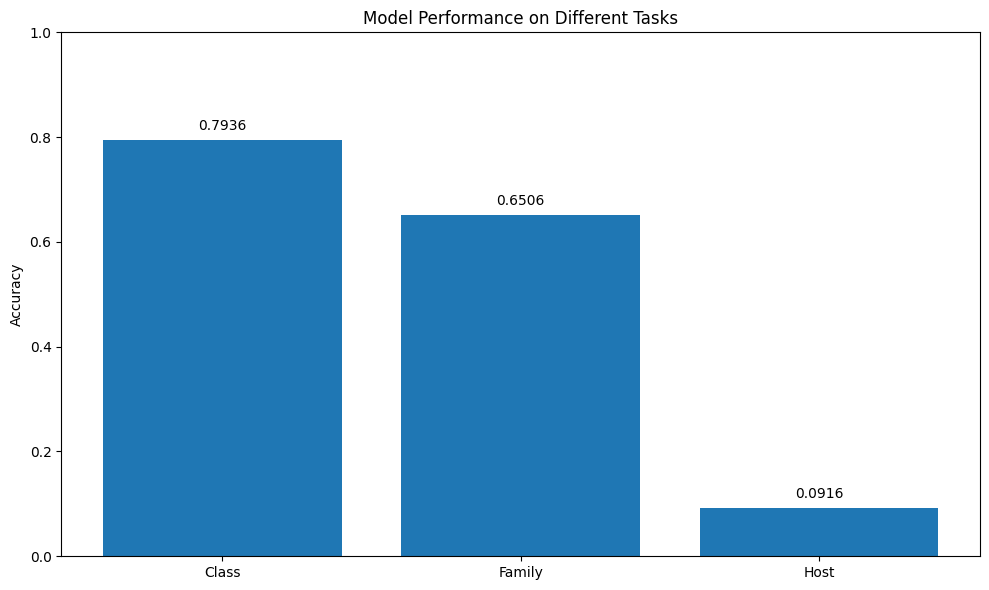


Testing completed!


In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics import classification_report, confusion_matrix

# Load the trained model and encoders
model_path = "../models/taxonomy_mlp_model.pt"
encoders_path = "../models/label_encoders.pkl"

# Load encoders and scaler
with open(encoders_path, "rb") as f:
    encoders = pickle.load(f)

genus_encoder = encoders["genus_encoder"]
family_encoder = encoders["family_encoder"]
class_encoder = encoders["class_encoder"]
host_encoder = encoders["host_encoder"]
scaler = encoders["scaler"]


# Define the model architecture (same as training)
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, genus_classes, family_classes, class_classes, host_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.genus_classifier = nn.Linear(256, genus_classes)
        self.family_classifier = nn.Linear(256, family_classes)
        self.class_classifier = nn.Linear(256, class_classes)
        self.host_classifier = nn.Linear(256, host_classes)

    def forward(self, x):
        shared_features = self.shared_layers(x)
        return {
            "genus": self.genus_classifier(shared_features),
            "family": self.family_classifier(shared_features),
            "class": self.class_classifier(shared_features),
            "host": self.host_classifier(shared_features),
        }


# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=embeddings_megaDNA_matrix.shape[1],  # Corrected variable name
    genus_classes=len(genus_encoder.classes_),
    family_classes=len(family_encoder.classes_),
    class_classes=len(class_encoder.classes_),
    host_classes=len(host_encoder.classes_),
).to(device)

# Load the trained weights
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()  # Set to evaluation mode


# Function to extract vOTU ID from header
def extract_votu_id(header):
    # Based on your example, the header is the vOTU ID itself
    return header


# Extract vOTU IDs from headers
votu_ids = [extract_votu_id(header) for header in headers_megaDNA_matrix]  # Corrected variable name

# Create DataFrame with embeddings and vOTU IDs
embeddings_df = pd.DataFrame(embeddings_megaDNA_matrix)  # Corrected variable name
embeddings_df["vOTU"] = votu_ids


# Define a function to test on a specific task
def test_on_task(task_name, metadata_df, id_column="vOTU", label_column=None):
    """
    Test the model on a specific task

    Parameters:
    - task_name: 'class', 'family', or 'host'
    - metadata_df: DataFrame containing the test data
    - id_column: Column name in metadata_df that contains the IDs
    - label_column: Column name in metadata_df that contains the labels
    """
    if label_column is None:
        if task_name == "class":
            label_column = "Class"
        elif task_name == "family":
            label_column = "Family"
        elif task_name == "host":
            label_column = "iphop_genus"

    # Merge embeddings with metadata
    merged_data = pd.merge(
        embeddings_df, metadata_df, left_on="vOTU", right_on=id_column, how="inner"
    )

    print(f"\n--- Testing on {task_name.upper()} task ---")
    print(f"Number of test samples: {len(merged_data)}")

    # Skip if no samples
    if len(merged_data) == 0:
        print(f"No samples found for {task_name} task. Skipping.")
        return None

    # Prepare features
    X = merged_data.iloc[:, : embeddings_megaDNA_matrix.shape[1]].values
    X = scaler.transform(X)  # Scale using the same scaler as training

    # Prepare labels
    if task_name == "class":
        encoder = class_encoder
        output_key = "class"
    elif task_name == "family":
        encoder = family_encoder
        output_key = "family"
    elif task_name == "host":
        encoder = host_encoder
        output_key = "host"

    # Handle unknown labels
    known_labels = set(encoder.classes_)
    test_labels = merged_data[label_column].values

    # Filter out samples with unknown labels
    valid_indices = [i for i, label in enumerate(test_labels) if label in known_labels]
    if len(valid_indices) < len(test_labels):
        print(
            f"Warning: {len(test_labels) - len(valid_indices)} samples have unknown labels and will be excluded"
        )

    if len(valid_indices) == 0:
        print(f"No valid samples with known labels for {task_name} task. Skipping.")
        return None

    X = X[valid_indices]
    test_labels = test_labels[valid_indices]

    # Encode labels
    y = encoder.transform(test_labels)

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X).to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = outputs[output_key].argmax(dim=1).cpu().numpy()

    # Calculate accuracy
    accuracy = (predictions == y).mean()
    print(f"{task_name.capitalize()} prediction accuracy: {accuracy:.4f}")

    # Generate classification report
    # Get the unique classes in the test set
    unique_classes = np.unique(y)
    # Get the corresponding class names
    class_names = [encoder.classes_[i] for i in unique_classes]

    # Print classification report with only the classes present in the test set
    print(classification_report(y, predictions, labels=unique_classes, target_names=class_names))

    # Return results for further analysis
    return {
        "accuracy": accuracy,
        "true_labels": y,
        "predictions": predictions,
        "label_names": encoder.classes_,
        "unique_classes": unique_classes,
        "class_names": class_names,
    }


# Test on Class task
class_results = test_on_task("class", metadata_matrix_class)

# Test on Family task
family_results = test_on_task("family", metadata_matrix_family)

# Test on Host task
host_results = test_on_task("host", metadata_matrix)

# Visualize results
accuracies = {}
if class_results:
    accuracies["Class"] = class_results["accuracy"]
if family_results:
    accuracies["Family"] = family_results["accuracy"]
if host_results:
    accuracies["Host"] = host_results["accuracy"]

plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Performance on Different Tasks")
for i, (task, acc) in enumerate(accuracies.items()):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha="center")
plt.tight_layout()
plt.show()


# Modified plot_confusion_matrix function to handle class subset
def plot_confusion_matrix(results, task_name):
    if results is None or len(results["unique_classes"]) > 20:
        return  # Skip if too many classes

    cm = confusion_matrix(
        results["true_labels"], results["predictions"], labels=results["unique_classes"]
    )
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {task_name}")
    plt.colorbar()
    tick_marks = np.arange(len(results["class_names"]))
    plt.xticks(tick_marks, results["class_names"], rotation=90)
    plt.yticks(tick_marks, results["class_names"])
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


# Plot confusion matrices if not too many classes
if family_results and len(family_results["label_names"]) <= 20:
    plot_confusion_matrix(family_results, "Family")

print("\nTesting completed!")

The weighted average weights by true class distribution
The micro average is influenced by how many predictions were made for each class
Accuracy is the number of correct predictions divided by the total number of predictions, = Weighted-average recall = Weighted-average precision

## evo2

In [2]:
metadata_matrix_class = pd.read_csv(
    "../dataset/matrix_metadata_class.tsv", sep="\t"
)  # Class info is in the Class column; this dataframe contains instances used for Class classification
metadata_matrix_family = pd.read_csv(
    "../dataset/matrix_metadata_family.tsv", sep="\t"
)  # Family info is in the Family column; this dataframe contains instances used for Family classification
metadata_matrix = pd.read_csv(
    "../dataset/matrix_metadata.tsv", sep="\t"
)  # Host info is in the iphop_genus column; this dataframe contains instances used for Host classification (the genus of the host)
# identifier for each phage: vOTU column

In [3]:
embeddings_evo2_matrix_small = np.load("../results/embeddings_evo2_matrix_small.npy")
headers_evo2_matrix_small = pd.read_csv("../results/headers_evo2_matrix_small.csv")
# headers are like: array(['vBRB_NODE_6_length_77065_cov_27.260070', 'vBRB_NODE_7_length_71429_cov_18.530725', ...
# id in headers corresponds to vOTU in the metadata_matrix

In [5]:
headers_evo2_matrix_small["header"][0]

'vO1A_40_NODE_337_length_10355_cov_6.336311'


--- Testing on CLASS task ---
Number of test samples: 1008
Class prediction accuracy: 0.3383
                precision    recall  f1-score   support

Caudoviricetes       1.00      0.34      0.51      1004
Faserviricetes       0.00      0.25      0.01         4

     micro avg       0.61      0.34      0.44      1008
     macro avg       0.50      0.29      0.26      1008
  weighted avg       1.00      0.34      0.50      1008


--- Testing on FAMILY task ---
Number of test samples: 16
Family prediction accuracy: 0.1429
                   precision    recall  f1-score   support

Autographiviridae       0.00      0.00      0.00         2
   Herelleviridae       0.00      0.00      0.00         1
       Inoviridae       0.33      0.25      0.29         4

        micro avg       0.33      0.14      0.20         7
        macro avg       0.11      0.08      0.10         7
     weighted avg       0.19      0.14      0.16         7


--- Testing on HOST task ---
Number of test samples: 102

/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/spica/Repos/megaDNA_matrix/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

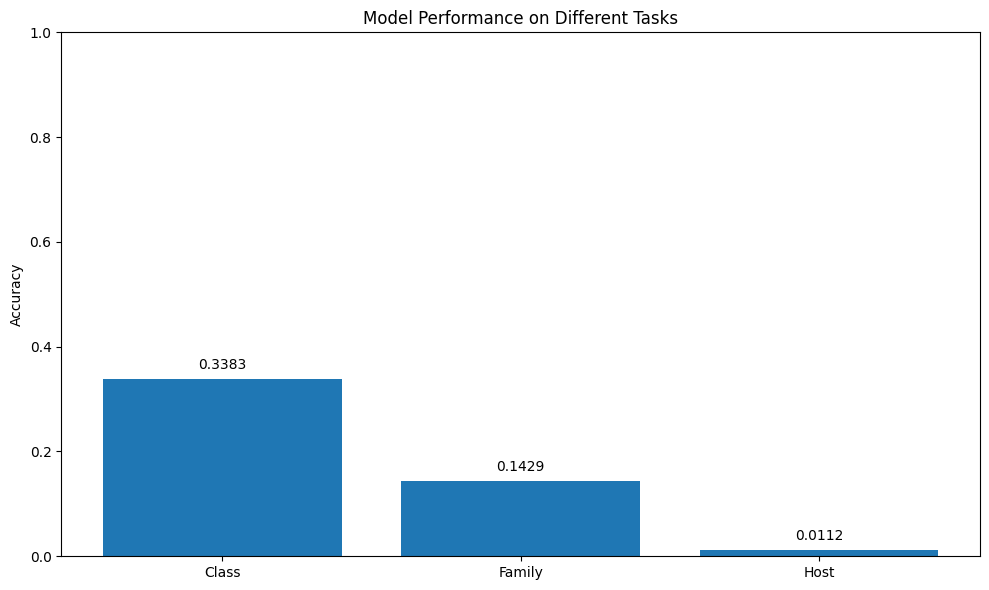


Testing completed!


In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.metrics import classification_report, confusion_matrix

# Load the trained model and encoders
model_path = "../models/taxonomy_mlp_model_evo2.pt"
encoders_path = "../models/label_encoders_evo2.pkl"

# Load encoders and scaler
with open(encoders_path, "rb") as f:
    encoders = pickle.load(f)

genus_encoder = encoders["genus_encoder"]
family_encoder = encoders["family_encoder"]
class_encoder = encoders["class_encoder"]
host_encoder = encoders["host_encoder"]
scaler = encoders["scaler"]


# Define the model architecture (same as training)
class TaxonomyMLP(nn.Module):
    def __init__(self, input_size, genus_classes, family_classes, class_classes, host_classes):
        super().__init__()
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )

        self.genus_classifier = nn.Linear(256, genus_classes)
        self.family_classifier = nn.Linear(256, family_classes)
        self.class_classifier = nn.Linear(256, class_classes)
        self.host_classifier = nn.Linear(256, host_classes)

    def forward(self, x):
        shared_features = self.shared_layers(x)
        return {
            "genus": self.genus_classifier(shared_features),
            "family": self.family_classifier(shared_features),
            "class": self.class_classifier(shared_features),
            "host": self.host_classifier(shared_features),
        }


# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyMLP(
    input_size=embeddings_evo2_matrix_small.shape[1],  # Corrected variable name
    genus_classes=len(genus_encoder.classes_),
    family_classes=len(family_encoder.classes_),
    class_classes=len(class_encoder.classes_),
    host_classes=len(host_encoder.classes_),
).to(device)

# Load the trained weights
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()  # Set to evaluation mode


# Function to extract vOTU ID from header
def extract_votu_id(header):
    # Based on your example, the header is the vOTU ID itself
    return header


# Extract vOTU IDs from headers
votu_ids = [
    extract_votu_id(header) for header in headers_evo2_matrix_small["header"]
]  # Corrected variable name

# Create DataFrame with embeddings and vOTU IDs
embeddings_df = pd.DataFrame(embeddings_evo2_matrix_small)  # Corrected variable name
embeddings_df["vOTU"] = votu_ids


# Define a function to test on a specific task
def test_on_task(task_name, metadata_df, id_column="vOTU", label_column=None):
    """
    Test the model on a specific task

    Parameters:
    - task_name: 'class', 'family', or 'host'
    - metadata_df: DataFrame containing the test data
    - id_column: Column name in metadata_df that contains the IDs
    - label_column: Column name in metadata_df that contains the labels
    """
    if label_column is None:
        if task_name == "class":
            label_column = "Class"
        elif task_name == "family":
            label_column = "Family"
        elif task_name == "host":
            label_column = "iphop_genus"

    # Merge embeddings with metadata
    merged_data = pd.merge(
        embeddings_df, metadata_df, left_on="vOTU", right_on=id_column, how="inner"
    )

    print(f"\n--- Testing on {task_name.upper()} task ---")
    print(f"Number of test samples: {len(merged_data)}")

    # Skip if no samples
    if len(merged_data) == 0:
        print(f"No samples found for {task_name} task. Skipping.")
        return None

    # Prepare features
    X = merged_data.iloc[:, : embeddings_evo2_matrix_small.shape[1]].values
    X = scaler.transform(X)  # Scale using the same scaler as training

    # Prepare labels
    if task_name == "class":
        encoder = class_encoder
        output_key = "class"
    elif task_name == "family":
        encoder = family_encoder
        output_key = "family"
    elif task_name == "host":
        encoder = host_encoder
        output_key = "host"

    # Handle unknown labels
    known_labels = set(encoder.classes_)
    test_labels = merged_data[label_column].values

    # Filter out samples with unknown labels
    valid_indices = [i for i, label in enumerate(test_labels) if label in known_labels]
    if len(valid_indices) < len(test_labels):
        print(
            f"Warning: {len(test_labels) - len(valid_indices)} samples have unknown labels and will be excluded"
        )

    if len(valid_indices) == 0:
        print(f"No valid samples with known labels for {task_name} task. Skipping.")
        return None

    X = X[valid_indices]
    test_labels = test_labels[valid_indices]

    # Encode labels
    y = encoder.transform(test_labels)

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X).to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = outputs[output_key].argmax(dim=1).cpu().numpy()

    # Calculate accuracy
    accuracy = (predictions == y).mean()
    print(f"{task_name.capitalize()} prediction accuracy: {accuracy:.4f}")

    # Generate classification report
    # Get the unique classes in the test set
    unique_classes = np.unique(y)
    # Get the corresponding class names
    class_names = [encoder.classes_[i] for i in unique_classes]

    # Print classification report with only the classes present in the test set
    print(classification_report(y, predictions, labels=unique_classes, target_names=class_names))

    # Return results for further analysis
    return {
        "accuracy": accuracy,
        "true_labels": y,
        "predictions": predictions,
        "label_names": encoder.classes_,
        "unique_classes": unique_classes,
        "class_names": class_names,
    }


# Test on Class task
class_results = test_on_task("class", metadata_matrix_class)

# Test on Family task
family_results = test_on_task("family", metadata_matrix_family)

# Test on Host task
host_results = test_on_task("host", metadata_matrix)

# Visualize results
accuracies = {}
if class_results:
    accuracies["Class"] = class_results["accuracy"]
if family_results:
    accuracies["Family"] = family_results["accuracy"]
if host_results:
    accuracies["Host"] = host_results["accuracy"]

plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values())
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Model Performance on Different Tasks")
for i, (task, acc) in enumerate(accuracies.items()):
    plt.text(i, acc + 0.02, f"{acc:.4f}", ha="center")
plt.tight_layout()
plt.show()


# Modified plot_confusion_matrix function to handle class subset
def plot_confusion_matrix(results, task_name):
    if results is None or len(results["unique_classes"]) > 20:
        return  # Skip if too many classes

    cm = confusion_matrix(
        results["true_labels"], results["predictions"], labels=results["unique_classes"]
    )
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix - {task_name}")
    plt.colorbar()
    tick_marks = np.arange(len(results["class_names"]))
    plt.xticks(tick_marks, results["class_names"], rotation=90)
    plt.yticks(tick_marks, results["class_names"])
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


# Plot confusion matrices if not too many classes
if family_results and len(family_results["label_names"]) <= 20:
    plot_confusion_matrix(family_results, "Family")

print("\nTesting completed!")